In [1]:
import math
import time
import copy
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from DebugRF import Dataset, FairnessMetric, FairnessDebuggingUsingMachineUnlearning

# Dataset class

In [2]:
'''Class for loading and preprocessing Adults Income Dataset'''
class AdultsIncomeDataset(Dataset): 
    def __init__(self, rootTrain, rootTest, column_names = None):
        Dataset.__init__(self, 
                         rootTrain = rootTrain,
                         rootTest = rootTest,
                         column_names = column_names)
        self.train = self.trainDataset
        self.test = self.testDataset
        self.trainProcessed, self.testProcessed = self.__preprocessDataset(self.train), self.__preprocessDataset(self.test)
        self.trainLattice, self.testLattice = self.__preprocessDatasetForCategorization(self.train), self.__preprocessDatasetForCategorization(self.test)
        
    def getDataset(self):
        return self.dataset, self.train, self.test

    def getDatasetWithNormalPreprocessing(self):
        return self.trainProcessed, self.testProcessed
    
    def getDatasetWithCategorizationPreprocessing(self, decodeAttributeValues = False):
        return self.trainLattice, self.testLattice

    def __preprocessDataset(self, dataset):
        df = copy.deepcopy(dataset)
        df = df.replace(" ", "", regex = True)
        # replace missing values (?) to nan and then drop the columns
        df = df.applymap(lambda d: np.nan if d == '?' else d)
        # dropping the NaN rows now
        df = df.dropna(axis = 0) 
        df["income"] = df["income"].apply(lambda x: x.replace(".", ""))
        df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
        df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0).astype(int) # 1 if old, 0 if young
        df['workclass'] = df['workclass'].map({'Never-worked': 0, 'Without-pay': 1, 'State-gov': 2, 'Local-gov': 3, 'Federal-gov': 4, 'Self-emp-inc': 5, 'Self-emp-not-inc': 6, 'Private': 7}).astype(int)
        df['education'] = df['education'].map({'Preschool': 0, '1st-4th': 1, '5th-6th': 2, '7th-8th': 3, '9th': 4, '10th': 5, '11th': 6, '12th': 7, 'HS-grad':8, 'Some-college': 9, 'Bachelors': 10, 'Prof-school': 11, 'Assoc-acdm': 12, 'Assoc-voc': 13, 'Masters': 14, 'Doctorate': 15}).astype(int)
        df['marital-status'] = df['marital-status'].map({'Married-civ-spouse': 2, 'Divorced': 1, 'Never-married': 0, 'Separated': 1, 'Widowed': 1, 'Married-spouse-absent': 2, 'Married-AF-spouse': 2}).astype(int)
        df['occupation'] = df['occupation'].map({'Adm-clerical': 0, 'Exec-managerial': 1, 'Handlers-cleaners': 2, 'Prof-specialty': 3, 'Other-service': 4, 'Sales': 5, 'Craft-repair': 6, 'Transport-moving': 7, 'Farming-fishing': 8, 'Machine-op-inspct': 9, 'Tech-support': 10, 'Protective-serv': 11, 'Armed-Forces': 12, 'Priv-house-serv': 13}).astype(int)
        df['relationship'] = df['relationship'].map({'Wife': 1 , 'Own-child': 0 , 'Husband': 1, 'Not-in-family': 0, 'Other-relative': 0, 'Unmarried': 0}).astype(int)
        df['race'] = df['race'].map({'White': 1, 'Asian-Pac-Islander': 0, 'Amer-Indian-Eskimo': 0, 'Other': 0, 'Black': 0}).astype(int)
        df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}).astype(int)
        # process hours
        df.loc[(df['hours-per-week'] <= 40), 'hours-per-week'] = 0
        df.loc[(df['hours-per-week'] > 40), 'hours-per-week'] = 1
        df = df.drop(columns=['fnlwgt', 'education-num', 'native-country', 'capital-gain', 'capital-loss'])
        df = df.reset_index(drop = True)
        return df
    
    def __preprocessDatasetForCategorization(self, dataset):
        df = copy.deepcopy(dataset)
        df = df.replace(" ", "", regex = True)
        df["income"] = df["income"].apply(lambda x: x.replace(".", ""))
        # Changing all Missing Data ?s to NaN
        df = df.applymap(lambda d: np.nan if d == '?' else d)
        # Drop Rows With NaNs
        df = df.dropna(axis = 0) 
        df = df.drop(columns=['fnlwgt', 'education-num', 'native-country', 'capital-gain', 'capital-loss'])
        # Converting Continuous Variables to Categorical
        df['age'] = pd.cut(df['age'], [0, 30, 60, 100], 
                labels = ['Young', 'Middle-aged', 'Senior'], 
                right = True, include_lowest = True)
        df['hours-per-week'] = pd.cut(df['hours-per-week'], [0, 20, 40, 100], 
                            labels = ['Part-time', 'Full-time', 'Over-time'], 
                            right = True, include_lowest = True)
        for col in df.columns:
            if col != 'income':
                df[col] = col + " = " + df[col].astype(str)
        df = df.reset_index(drop = True)
        return df

# Experiment

In [3]:
myDataset = AdultsIncomeDataset(rootTrain = 'Dataset/adulttrain.csv', rootTest = 'Dataset/adulttest.csv')

In [4]:
fairnessDebug = FairnessDebuggingUsingMachineUnlearning(myDataset,
                                                        ["sex", 1, 0],
                                                        "income",
                                                        FairnessMetric.PP)
print("OriginalAccuracy: " + fairnessDebug.getAccuracy() + ", originalSP: " + str(fairnessDebug.getDatasetStatisticalParity()) + ", originalPP: " + str(fairnessDebug.getDatasetPredictiveParity()) + ", originalEO: " + str(fairnessDebug.getDatasetEqualizingOddsParity()))

OriginalAccuracy: 77.19123505976096%, originalSP: 0.07746331100686638, originalPP: 0.281567099694622, originalEO: -0.03845583317984147


level: 0
level: 1
level: 2
level: 3


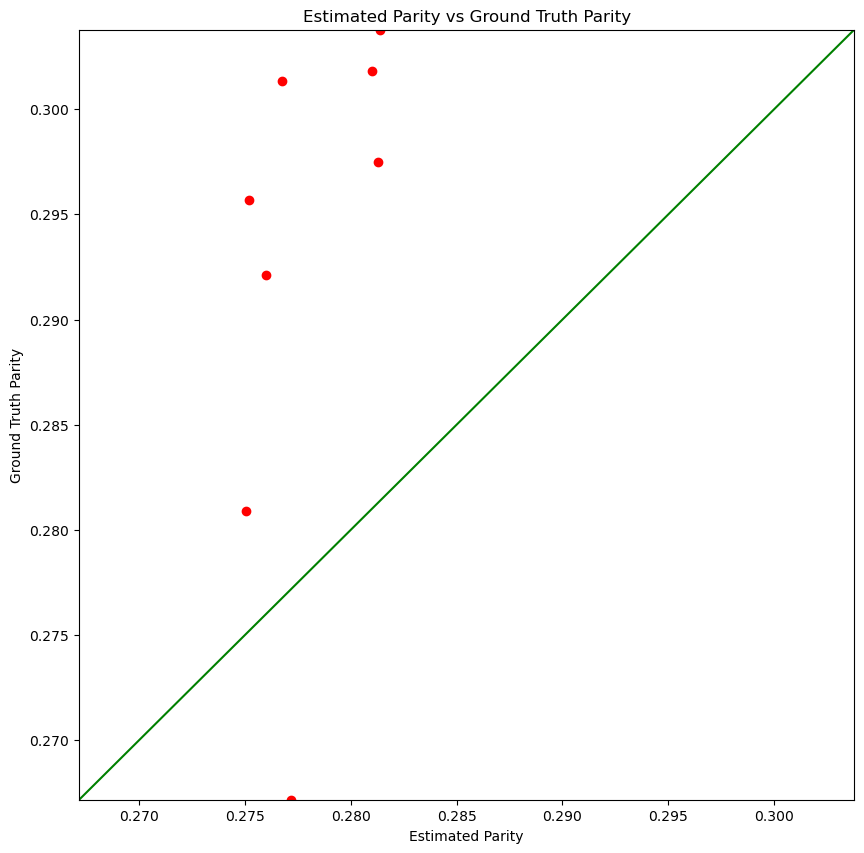

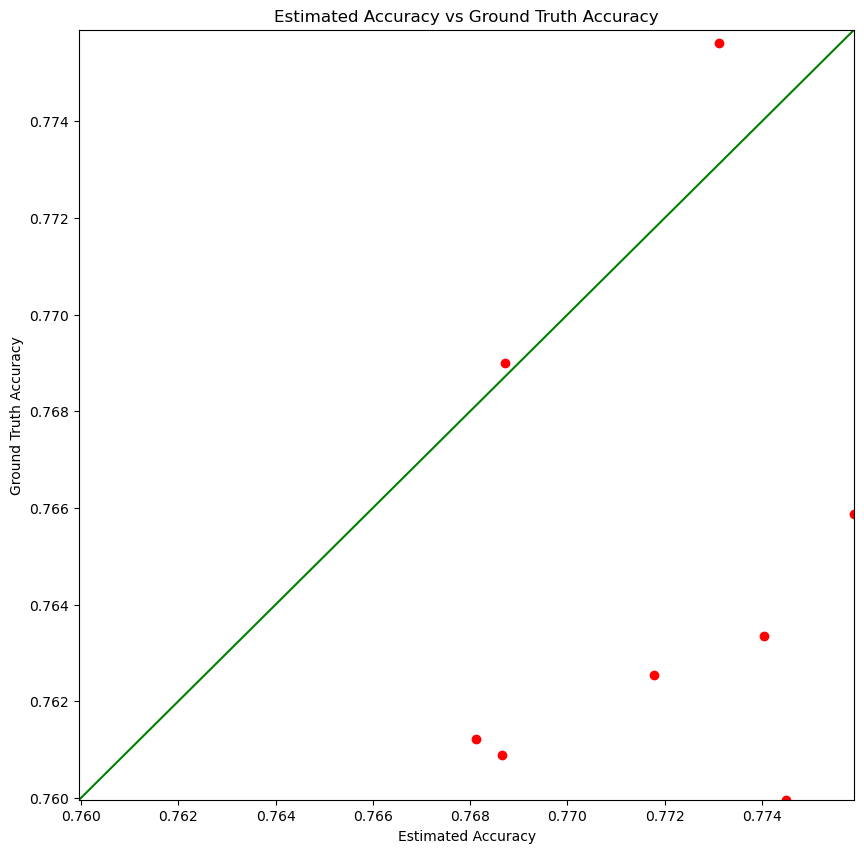

,Subset,Size,Support,Parity,GT_Parity,Accuracy,GT_Accuracy,timeElapsedToTrain,timeElapsedToDelete,Parity_Reduction,Accuracy_Reduction
0,"{'education = Bachelors', 'sex = Female'}",1522,0.05046084477156687,0.2750271468475957,0.2808788400405197,0.7731075697211155,0.7756308100929615,0.5303633213043213,0.28977465629577637,2.322698,-0.15483870967741634
1,"{'occupation = Craft-repair', 'education = HS-...",1903,0.06309263311451495,0.27517754063387345,0.29568253287319163,0.7686586985391767,0.7608897742363878,0.5091402530670166,0.25693321228027344,2.269285,0.42150537634407703
2,{'occupation = Craft-repair'},4030,0.1336118294542802,0.2760076158353933,0.29210900137115603,0.7681274900398406,0.7612217795484728,0.5122075080871582,0.5570180416107178,1.974479,0.49032258064516376
3,"{'education = Bachelors', 'hours-per-week = Fu...",2724,0.09031231350706187,0.2767633747908954,0.3013309484627589,0.7758964143426295,0.7658698539176627,0.5275716781616211,0.5110783576965332,1.706068,-0.5161290322580641
4,"{'education = Some-college', 'relationship = H...",2368,0.0785093826669319,0.2771669006502305,0.2671667428848879,0.7687250996015936,0.7689907038512617,0.5202412605285645,0.33323121070861816,1.562753,0.4129032258064484
5,"{'education = Some-college', 'hours-per-week =...",1836,0.0608712950069624,0.2809858407455368,0.3018007286112267,0.7745019920318725,0.7599601593625498,0.5370843410491943,0.2418992519378662,0.206437,-0.3354838709677474
6,"{'age = Middle-aged', 'relationship = Not-in-f...",4404,0.14601153769643924,0.28127878184805494,0.2974818298191974,0.7740371845949535,0.7633466135458168,0.5292325019836426,0.7794880867004395,0.102398,-0.27526881720430374
7,"{'education = Bachelors', 'relationship = Not-...",1573,0.05215171407731583,0.2813939134976024,0.3037805465297783,0.7717795484727755,0.7625498007968128,0.522209644317627,0.29535841941833496,0.061508,0.01720430107527168


In [9]:
bias_inducing_subsets = fairnessDebug.latticeSearchSubsets(4, (0.05, 0.15), "normal", True)
bias_inducing_subsets

# How good are the explanations?

In [10]:
# Example subsets to check why they are bias-inducing
subsets = [{'marital-status = Married-civ-spouse', 'occupation = Exec-managerial'},
{'age = Middle-aged', 'occupation = Exec-managerial'},
{'occupation = Exec-managerial', 'race = White'},
{'age = Middle-aged', 'education = Some-college'},
{'occupation = Exec-managerial'}
]

In [11]:
featImp = fairnessDebug.getFeatureImportanceChanges(subsets)
featImp

,Subset,relationship,marital-status,education,occupation,hours-per-week,sex,age,workclass,race
0,"{'occupation = Exec-managerial', 'marital-stat...",0.5609166546805693,-1.8742985262149496,5.199762849417279,-15.474951102327598,0.32418792009803576,-10.123739073056216,11.798326995191282,18.416687998385402,90.75441594355566
1,"{'occupation = Exec-managerial', 'age = Middle...",4.026529657579869,6.277591952480843,-1.8294848271203148,-22.95651003821307,-9.61770298889807,-22.450496274379077,6.542686918361836,30.132593397926293,109.24583987776452
2,"{'occupation = Exec-managerial', 'race = White'}",17.948306278165965,-11.56609477060789,0.12736973875998783,-21.694969532400602,-14.004749647334929,-16.55014801657159,-8.062777076793468,49.20861842998432,46.98982690252706
3,"{'education = Some-college', 'age = Middle-aged'}",9.31006014176576,-24.814334653412566,17.136637926900136,6.310228564663513,-5.535203732739163,-21.555774457441043,-12.281363607182874,24.502291877948004,107.95299095597586
4,{'occupation = Exec-managerial'},15.61404333476637,-6.7212607518364536,-4.932294057672702,-13.87182383873894,-21.066396619339855,6.1210252903315405,-10.449878929271978,40.148270531798566,149.78519690645956


In [12]:
inference = fairnessDebug.drawInferencesFromResultSubsets(subsets, "Female", "Male")
inference

,Subset,Size,Support,SupportRange,Total_Female,Total_Male,Female_1s,Male_1s,Female_0s,Male_0s
0,Entire Train Dataset,30162,1.0,100%,9782,20380,0.11,0.31,0.89,0.69
1,"{'occupation = Exec-managerial', 'marital-stat...",2395,0.07940454876997546,5-10%,239,2156,0.25,0.26,0.75,0.74
2,"{'occupation = Exec-managerial', 'age = Middle...",3006,0.0996618261388502,5-10%,787,2219,0.25,0.26,0.75,0.74
3,"{'occupation = Exec-managerial', 'race = White'}",3595,0.11918970890524501,10-30%,968,2627,0.26,0.26,0.74,0.74
4,"{'education = Some-college', 'age = Middle-aged'}",3715,0.12316822491877197,10-30%,1196,2519,0.24,0.26,0.76,0.74
5,{'occupation = Exec-managerial'},3992,0.1323519660499967,10-30%,1143,2849,0.24,0.26,0.76,0.74
